# Higher Dimensional Data

In [1]:
import pathlib 
from collections import defaultdict

import h5py
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize
import matplotlib.cm as cm

from bluesky_tutorial_utils import nexus, fetch

In [2]:
# Un-comment this for better-looking plots on high-resolution screens.
# %config InlineBackend.figure_format = 'retina'

In [3]:
fetch.rsoxs_simulation_data();

## Working with Multiple xArrays: Gathering Data

### Build Index Table (Table of Contents)

In [4]:
def build_pandas_index(nxs_path):
    nxs_path = pathlib.Path(nxs_path)
    nxs_files = list(nxs_path.glob('*nxs'))
    
    #progress = ipywidgets.IntProgress(0,0,len(nxs_files))
    #display(progress)
    
    index_table = []
    for i,nxs_file in enumerate(nxs_files):
        #progress.value = i
        with h5py.File(nxs_file,'r') as nxs:
            notes = nxs[u'entry/instrument/simulation_engine/notes']
            config =  {k:v[()] for k,v in notes.items()}
            config['nxs'] = nxs_file
            index_table.append(config)
    return pd.DataFrame(index_table)

In [5]:
toc = build_pandas_index('./rsoxs_simulation_data//')

In [6]:
toc

,EndAngle,EndEnergy,Energy,IncrementAngle,IncrementEnergy,NumThreads,NumX,NumY,NumZ,PhysSize,Radius,StartAngle,StartEnergy,nxs
0,360.0,2005.0,2000.0,2.0,1.0,4,512,512,128,5.0,10.0,0.0,2000.0,rsoxs_simulation_data/512-512-128-5.0-10.0-020...
1,360.0,290.0,288.0,2.0,1.0,4,512,512,128,5.0,5.0,0.0,285.0,rsoxs_simulation_data/512-512-128-5.0-5.0-0028...
2,360.0,2005.0,2003.0,2.0,1.0,4,512,512,128,5.0,5.0,0.0,2000.0,rsoxs_simulation_data/512-512-128-5.0-5.0-0200...
3,360.0,2005.0,2005.0,2.0,1.0,4,512,512,128,5.0,40.0,0.0,2000.0,rsoxs_simulation_data/512-512-128-5.0-40.0-020...
4,360.0,2005.0,2003.0,2.0,1.0,4,512,512,128,5.0,20.0,0.0,2000.0,rsoxs_simulation_data/512-512-128-5.0-20.0-020...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,360.0,2005.0,2005.0,2.0,1.0,4,512,512,128,5.0,80.0,0.0,2000.0,rsoxs_simulation_data/512-512-128-5.0-80.0-020...
86,360.0,290.0,286.0,2.0,1.0,4,512,512,128,5.0,5.0,0.0,285.0,rsoxs_simulation_data/512-512-128-5.0-5.0-0028...
87,360.0,20005.0,20001.0,2.0,1.0,4,512,512,128,5.0,40.0,0.0,20000.0,rsoxs_simulation_data/512-512-128-5.0-40.0-200...
88,360.0,290.0,289.0,2.0,1.0,4,512,512,128,5.0,10.0,0.0,285.0,rsoxs_simulation_data/512-512-128-5.0-10.0-002...


In [7]:
toc.describe().loc[['count','min','max']]

,EndAngle,EndEnergy,Energy,IncrementAngle,IncrementEnergy,NumThreads,NumX,NumY,NumZ,PhysSize,Radius,StartAngle,StartEnergy
count,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
min,360.0,290.0,285.0,2.0,1.0,4.0,512.0,512.0,128.0,5.0,5.0,0.0,285.0
max,360.0,20005.0,20005.0,2.0,1.0,4.0,512.0,512.0,128.0,5.0,80.0,0.0,20000.0


### Select subset of data From Index

In [8]:
sdf = toc.query('Radius==40.0 & EndAngle==360.0 & PhysSize==5 & NumX==512')
sdf = sdf.sort_values('Energy')
sdf.describe().loc[['count','min','max']]

,EndAngle,EndEnergy,Energy,IncrementAngle,IncrementEnergy,NumThreads,NumX,NumY,NumZ,PhysSize,Radius,StartAngle,StartEnergy
count,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
min,360.0,290.0,285.0,2.0,1.0,4.0,512.0,512.0,128.0,5.0,40.0,0.0,285.0
max,360.0,20005.0,20005.0,2.0,1.0,4.0,512.0,512.0,128.0,5.0,40.0,0.0,20000.0


### Gather Data

In [9]:
def gather(df):
    coords = defaultdict(list)
    data_arrays = []
    for row_index,row in df.iterrows():
        da_img = nexus.read_singleimg_nxs(row['nxs'])
        data_arrays.append(da_img)
        
        for col_index,value in row.iteritems():
            if col_index=='nxs':
                continue
            coords[col_index].append(value)
    return data_arrays,coords

In [10]:
data_arrays,coords = gather(sdf)

In [11]:
data_arrays

[<xarray.DataArray 'I' (Qx: 512, Qy: 512)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)
 Coordinates:
   * Qx       (Qx) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
   * Qy       (Qy) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
 Attributes:
     lazy:     False,
 <xarray.DataArray 'I' (Qx: 512, Qy: 512)>
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float16)
 Coordinates:
   * Qx       (Qx) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
   * Qy       (Qy) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
 

In [12]:
coords

defaultdict(list,
            {'EndAngle': [360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0,
              360.0],
             'EndEnergy': [290.0,
              290.0,
              290.0,
              290.0,
              290.0,
              290.0,
              2005.0,
              2005.0,
              2005.0,
              2005.0,
              2005.0,
              2005.0,
              20005.0,
              20005.0,
              20005.0,
              20005.0,
              20005.0,
              20005.0],
             'Energy': [285.0,
              286.0,
              287.0,
              288.0,
              289.0,
              290.0,
              2000.0,
              2001.0,
 

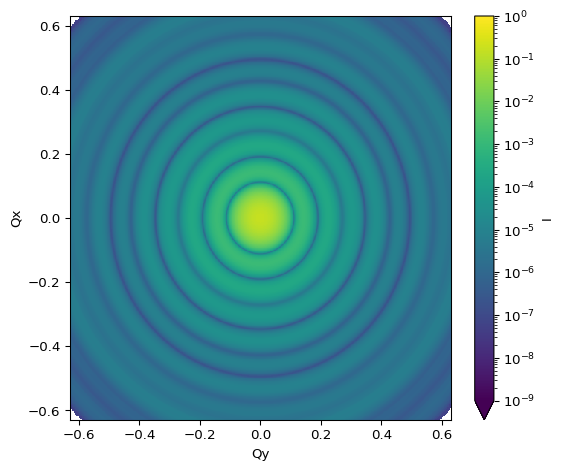

In [13]:
data_arrays[1].plot(norm=LogNorm(1e-9,1),aspect=1.2,size=5)

## Multiple xArrays: simple xr.concat

In [14]:
sdf = toc.query('Radius==40.0 & EndAngle==360.0 & PhysSize==5 & NumX==512')
sdf = sdf.sort_values('Energy')
display(sdf.describe().loc[['count','min','max']])

data_arrays,coords = gather(sdf)

da = xr.concat(data_arrays,dim='Energy')
da

,EndAngle,EndEnergy,Energy,IncrementAngle,IncrementEnergy,NumThreads,NumX,NumY,NumZ,PhysSize,Radius,StartAngle,StartEnergy
count,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
min,360.0,290.0,285.0,2.0,1.0,4.0,512.0,512.0,128.0,5.0,40.0,0.0,285.0
max,360.0,20005.0,20005.0,2.0,1.0,4.0,512.0,512.0,128.0,5.0,40.0,0.0,20000.0


<xarray.DataArray 'I' (Energy: 18, Qx: 512, Qy: 512)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float16)
Coordinates:
  * Qx       (Qx) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
  * Qy       (Qy) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
Dimensions without coordinates: Energy
Attributes:
    lazy:     False

In [15]:
da = da.assign_coords(Energy=sdf.Energy.values)
da

<xarray.DataArray 'I' (Energy: 18, Qx: 512, Qy: 512)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float16)
Coordinates:
  * Qx       (Qx) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
  * Qy       (Qy) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
  * Energy   (Energy) float64 285.0 286.0 287.0 288.0 ... 2e+04 2e+04 2.000e+04
Attributes:
    lazy:     False

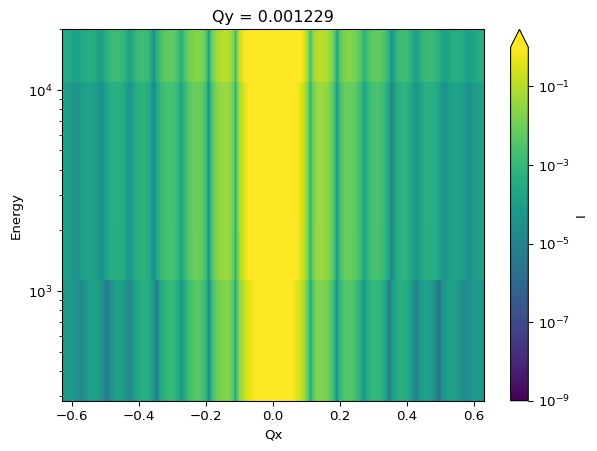

In [16]:
da.sel(Qy=0,method='nearest').plot(norm=LogNorm(1e-9,1),yscale='log')

In [17]:
# da.plot(col='Energy',col_wrap=3,norm=LogNorm(1e-9,1))

## Building xArrays: Multi-Index

In [18]:
sdf = toc.query('EndAngle==360.0 & PhysSize==5 & NumX==512')
sdf = sdf.sort_values(['Energy','Radius'])
display(sdf.describe().loc[['count','min','max']])

,EndAngle,EndEnergy,Energy,IncrementAngle,IncrementEnergy,NumThreads,NumX,NumY,NumZ,PhysSize,Radius,StartAngle,StartEnergy
count,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0
min,360.0,290.0,285.0,2.0,1.0,4.0,512.0,512.0,128.0,5.0,5.0,0.0,285.0
max,360.0,20005.0,20005.0,2.0,1.0,4.0,512.0,512.0,128.0,5.0,80.0,0.0,20000.0


In [19]:
data_arrays,coords = gather(sdf)

da = xr.concat(data_arrays,dim=['Energy','Radius'])

ValueError: conflicting sizes for dimension 'concat_dim': length 2 on 'concat_dim' and length 90 on <this-array>

hmmm...that didn't work...


Let's try a multi-index

In [20]:
keys =  ['Energy','Radius']
tuples = [(i,j) for i,j in sdf[keys].values]
index = pd.MultiIndex.from_tuples(tuples,names=keys)
index.name = 'system'
da = xr.concat(data_arrays,dim=index)
da

<xarray.DataArray 'I' (system: 90, Qx: 512, Qy: 512)>
array([[[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]],

       [[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]],

       [[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]],

       ...,

       [[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]],

       [[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]],

       [[0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 6.e-08, 0.e+00, 0.e+00],
        ...,
        [0.e+00, 0.e+00, 6.e-08, ..., 1.e-07, 6.e-08, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 6.e-08, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, ..., 0.e+00, 0.e+00, 0.e+00]]],
      dtype=float16)
Coordinates:
  * Qx       (Qx) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
  * Qy       (Qy) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
  * system   (system) MultiIndex
  - Energy   (system) float64 285.0 285.0 285.0 ... 2.000e+04 2.000e+04
  - Radius   (system) float64 5.0 10.0 20.0 40.0 80.0 ... 10.0 20.0 40.0 80.0
Attributes:
    lazy:     False

In [21]:
da.sel(Energy=285.,method='nearest')

<xarray.DataArray 'I' (Radius: 5, Qx: 512, Qy: 512)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float16)
Coordinates:
  * Qx       (Qx) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
  * Qy       (Qy) float16 -0.6284 -0.626 -0.6235 -0.621 ... 0.6235 0.626 0.6284
  * Radius   (Radius) float64 5.0 10.0 20.0 40.0 80.0
Attributes:
    lazy:     False

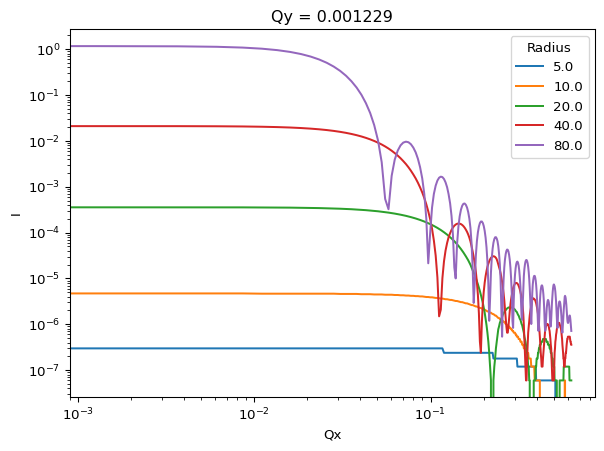

In [22]:
da.sel(Energy=285.,Qy=0,method='nearest').plot.line(x='Qx',yscale='log',xscale='log')#(norm=LogNorm(1e-9,1))

/home/travis/virtualenv/python3.7.1/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


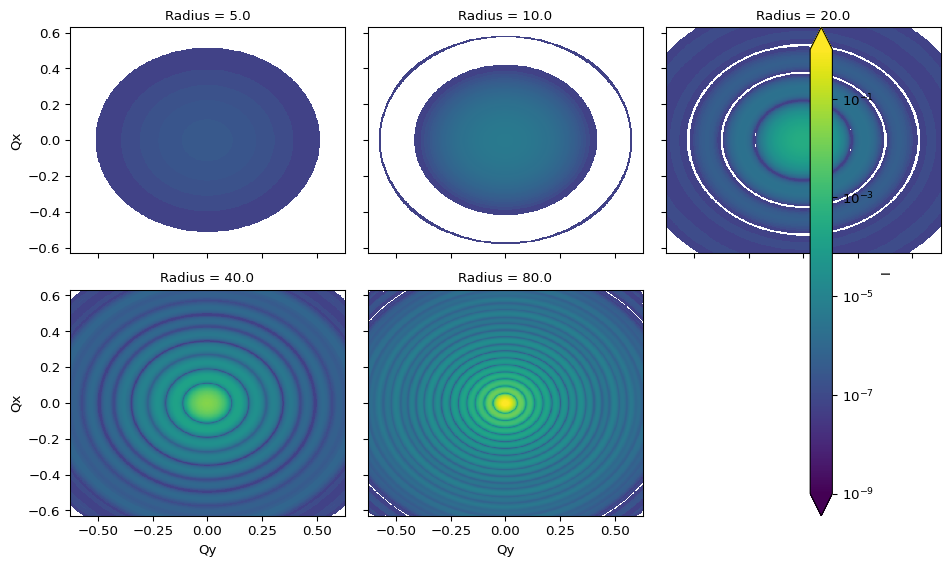

In [23]:
da.sel(Energy=285.,method='nearest').plot(col='Radius',col_wrap=3,norm=LogNorm(1e-9,1))